In [1]:
import sys
import pandas as pd
import utils
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import statsmodels.formula.api as sm
from sklearn.metrics import roc_auc_score
from collections import Counter
from timeit import default_timer as timer
import pickle

In [2]:
args = sys.argv

cohort_list =  'Hispanic_k5&Hispanic_k6'#'T2D_k6&T2D_k7'#"CRC_k6&CRC_k7"#'Thomas_k6&Thomas_k7' #'T2D_k6&T2D_k7' # 'AGP_max_k5&AGP_max_k6&AGP_max_k7'
phenotype = "antibiotic"#"bin_antibiotic_last_year"#"bin_t2d"#'bin_crc_normal'#'bmi_corrected'#
pred_bool = 0
args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list , 'kmer', 'BatchCorrected', phenotype, 1, 0,
        10, 'minervaclrscale',"MINERVA_grid_trans_clr_scale",1,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'raw',"raw_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'combat',"ComBat_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'limma',"limma_grid_trans_none",0,pred_bool]

# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc',cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#          10, 'bmc',"bmc_grid_trans_none",0,pred_bool]




In [3]:

print(args)


greater_folder = args[1] # what folder do you save your different datasets in
study_names = args[2].split("&")  # what is the name of the dataset (tells the program which folder to check)
data_type = args[3] # type of data. kmer vs OTU

prefix_name = args[4] # what is the prefix of the file name
column_of_interest = args[5] # what is the phenotype you are predicting (use the same name in the column of the metadata you want to predict), this programs reads from metadata.txt

norm_input = bool(int(args[6]))
map_with_accession = bool(int(args[7]))
num_pcs = 20
num_pcs = int(args[8])
special_name = args[9]
method = args[10]
if data_type == "otu" or data_type == "kmer":
    data_folders = [greater_folder + "/data/" + study_name + "/" for study_name in study_names] 
    metadata_folder =   greater_folder + "/data/" + study_names[0] + "/"  
else:
    data_folders = [greater_folder + "/data/" + study_name + "/" + "protect_" + column_of_interest + "/" + prefix_name + "_"  for study_name in study_names] 
    metadata_folder = greater_folder + "/data/" + study_names[0] + "/" 
PC = bool(int(args[11]))
pred = bool(int(args[12]))

['./run_MINERVA_test_train_grid.sh', '/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', 'Hispanic_k5&Hispanic_k6', 'kmer', 'BatchCorrected', 'antibiotic', 1, 0, 10, 'minervaclrscale', 'MINERVA_grid_trans_clr_scale', 1, 0]


In [4]:
if pred:
    all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_prediction_grid.pkl", "rb" ))
    trainKey = 'train_pearson_trained'
    testKey ='test_pearson_trained'
    valKey = 'val_pearson_trained'
else:
    all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_tt_grid.pkl", "rb" ))
    trainKey = 'train_auc_trained'
    testKey ='test_auc_trained'
    valKey = 'val_auc_trained'
            

In [19]:
all_datasets_dict

{'dataset0': {'number samples': [988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989,
   988,
   988,
   988,
   989,
   989],
  'PC0': {'train_best_params': {0: {'criterion': 'entropy',
     'max_depth': 1,
     'max_features': 0.1,
     'min_samples_leaf': 10,
     'min_samples_split': 5,
     'n_estimators': 1000},
    1: {'criterion': 'entropy',
     'max_depth': 1,
     'max_features': 0.5,
     'min_samples_leaf': 10,
     'min_samples_split': 5,
     'n_estimators': 1500},
    2: {'criterion': 'gini',
     'max_depth': 1,
     'max_features': 0.5,
     'min_samples_leaf': 10,
     'min_samples_split': 5,
     'n_estimators': 100},
    3: {'criterion': 'gini',
     'max_depth': 1,


In [6]:
import matplotlib.pyplot as plt

# check MINERVA PCs


train_auc = []
test_auc = []
dataset_num = 1
for i in range(10):
      
    if not PC:
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][trainKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][testKey])
    else:   
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][trainKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey])
    
x = np.array(train_auc)
y = np.array(test_auc)
plt.scatter( x,  y)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title(study_names[dataset_num] + " MINERVA")
plt.show()

<Figure size 640x480 with 1 Axes>

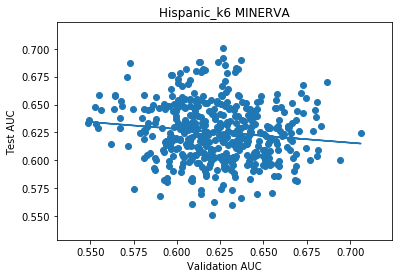

In [7]:
# check MINERVA PCs
dataset_num = 1

train_auc = []
test_auc = []
for i in range(10):
    if not PC:
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][valKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][testKey])
    else:   
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][valKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey])
    
x = np.array(train_auc)
y = np.array(test_auc)
plt.scatter( x,  y)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Validation AUC")
plt.ylabel("Test AUC")
plt.title(study_names[dataset_num] +" MINERVA")
plt.show()

In [8]:
method

'MINERVA_grid_trans_clr_scale'

0


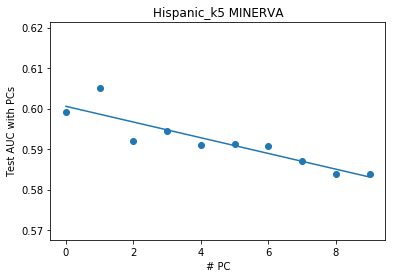

1


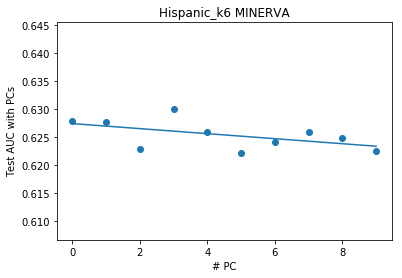

In [9]:
#check overall correlation or trend

auc_collection = dict()
pc_number_collection = dict()


for dataset_num in range(len(study_names)):
    print(dataset_num)
    auc_val = []
    pc_num = []
    auc = []
    plot_train = False
    plot_validation = False
    
    if not PC:
        auc_val.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)][valKey]))
    else:

        if plot_train:
            ylab_input = "Train AUC with PCs"
        else:
            if plot_validation:
                ylab_input = "Validation AUC with PCs"
            else:
                ylab_input = "Test AUC with PCs"
        for i in range(10):
            pc_num.append(i)
            auc_val.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][valKey]))
            if plot_train:
                auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][trainKey]))
            else:
                if plot_validation:
                    auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][valKey]))
                else:
                    auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey]))

            #export PC result for plotting
            output_dict = dict()
            if not pred:
                methodkey = "MINERVA_grid_PC" + str(i) + "_trans_clr_scale"
                output_dict[ methodkey]=dict()
                output_dict[ methodkey]['Random Forest'] = dict()
                output_dict[ methodkey]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey]
                pickle.dump(output_dict , open( data_folders[dataset_num] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + "MINERVA_grid_PC" + str(i) + "_trans_clr_scale" + "_classification_auc.pkl", "wb" ) )


            else:
                output_dict['pearson'] = all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey]
                pickle.dump(output_dict , open( data_folders[dataset_num] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + "MINERVA_grid_PC" + str(i) + "_trans_clr_scale" + "_pearson_and_mse.pkl", "wb" ) )




    
       
        
        
    
        
        
        x = np.array(pc_num)
        y = np.array(auc)
        plt.scatter( x,  y)

        m, b = np.polyfit(x, y, 1)

        plt.plot(x, m*x + b)

        plt.xlabel("# PC")
        plt.ylabel(ylab_input)
        plt.title(study_names[dataset_num] + " MINERVA")
        plt.show()
        #auc_collection.append(auc)
    
    
    auc_collection["dataset" + str(dataset_num)] = auc_val
    if PC:
        pc_number_collection["dataset" + str(dataset_num)] = pc_num
    

# plt.plot(x1, y1, "g")



# plt.plot(x2, y2, "r")

In [10]:
plt.show()


In [11]:
if PC:
    
    best_pc_per_dataset = []
    best_auc_per_dataset = []

    for dataset_num in range(len(study_names)):


        index_best_pc = auc_collection["dataset" + str(dataset_num)].index(max(auc_collection["dataset" + str(dataset_num)]))
        best_auc_per_dataset.append(auc_collection["dataset" + str(dataset_num)][index_best_pc])
        best_pc_per_dataset.append(index_best_pc)
else:
    best_auc_per_dataset = []
    for dataset_num in [0,1]:
        best_auc_per_dataset.append(auc_collection["dataset" + str(dataset_num)])

In [12]:
dataset_num

1

In [13]:
auc_collection["dataset" + str(dataset_num)]

[0.630277566535142,
 0.6297864063507713,
 0.6258396894053004,
 0.6279272257852162,
 0.623900104569389,
 0.6150998043969109,
 0.617597012031054,
 0.6182102324763477,
 0.6209095302865261,
 0.6200285343846226]

In [14]:
if PC:
    best_kmer = best_auc_per_dataset.index(max(best_auc_per_dataset))
    best_pc = best_pc_per_dataset[best_kmer]
else:
    best_kmer = best_auc_per_dataset.index(max(best_auc_per_dataset))



In [15]:
output_dict = dict()



print("best_kmer" + str(study_names[best_kmer]))
if pred:
    
    if PC:
        all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
        output_dict['pearson'] = all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
    else:
        output_dict['pearson'] = all_datasets_dict['dataset' + str(best_kmer)][testKey]
    
    
    pickle.dump(output_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_pearson_and_mse.pkl", "wb" ) )
       
else:
    output_dict[method]=dict()
    output_dict[method]['Random Forest'] = dict()
    if PC:
        all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
        output_dict[method]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
    else:
        output_dict[method]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)][testKey]
    
    
    pickle.dump(output_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_classification_auc.pkl", "wb" ) )
       

best_kmerHispanic_k6


In [16]:
data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_classification_auc.pkl"

'/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/data/Hispanic_k6/kmer_BatchCorrected_antibiotic_MINERVA_grid_trans_clr_scale_classification_auc.pkl'

In [17]:
output_dict

{'MINERVA_grid_trans_clr_scale': {'Random Forest': {'auc_all': [0.6599620933740764,
    0.5894867133408115,
    0.6025219510308282,
    0.6001960784313726,
    0.6869411764705882,
    0.6033342358720458,
    0.6257300893513325,
    0.6220167872200518,
    0.6196078431372549,
    0.6459411764705882,
    0.6412408617955363,
    0.6298688740184891,
    0.655165744787839,
    0.5994313725490196,
    0.6334509803921569,
    0.6513364019649557,
    0.6510656403512164,
    0.6005492592735853,
    0.6201568627450981,
    0.6205098039215686,
    0.5888291494217305,
    0.6306811588597068,
    0.6483580242138243,
    0.6272549019607843,
    0.6140784313725491,
    0.6268131358062894,
    0.5682706068928172,
    0.6668084941786253,
    0.6794117647058824,
    0.6046274509803922,
    0.6025606312613623,
    0.6902487138823347,
    0.5828337136889336,
    0.6267058823529411,
    0.621921568627451,
    0.6037403782926546,
    0.6704057556183036,
    0.6396936525741693,
    0.5606470588235294,
    0.

In [18]:
np.mean( all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey])

0.6278319284132806